In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from google.colab import files

In [86]:
!pip install opendatasets
import opendatasets as od

In [87]:
od.download("https://www.kaggle.com/datasets/alxmamaev/flowers-recognition")

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


Total Images per Class:
daisy: 764 images
tulip: 984 images
sunflower: 733 images
dandelion: 1052 images
rose: 784 images


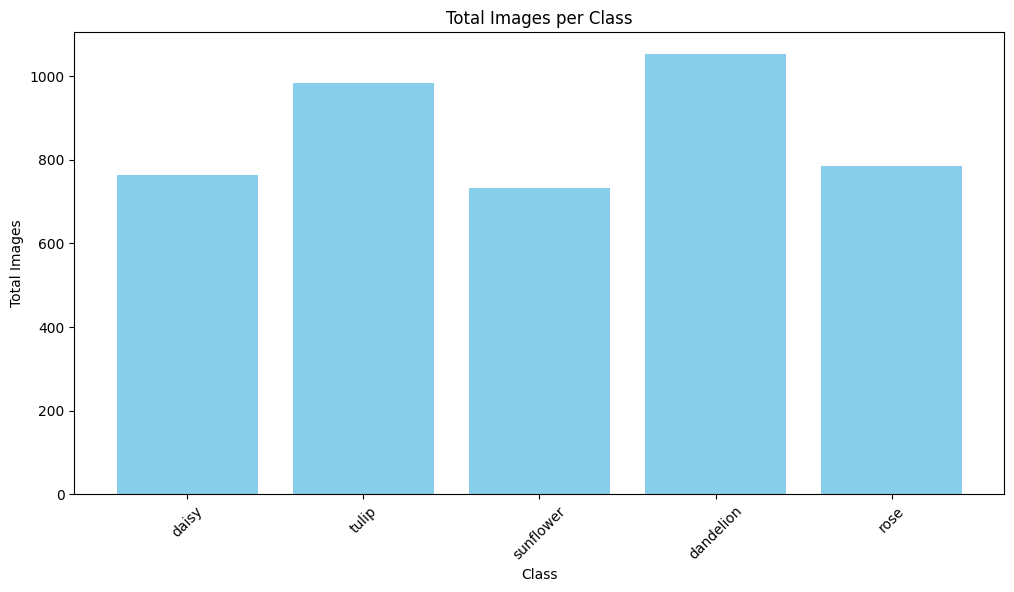

In [88]:
# Dataset directory
dataset_path = '/content/flowers-recognition/flowers'

# Initialize a dictionary to store the total number of images for each class
total_images_per_class = {}

# Loop through each folder in the dataset directory
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    if os.path.isdir(folder_path):
        # Count the total number of images in each folder
        total_images = len(os.listdir(folder_path))

        # Add information to the dictionary
        total_images_per_class[folder_name] = total_images

# Print the total number of images for each class
print("Total Images per Class:")
for class_name, total_images in total_images_per_class.items():
    print(f"{class_name}: {total_images} images")

# Display the data in a bar chart
plt.figure(figsize=(12, 6))
plt.bar(total_images_per_class.keys(), total_images_per_class.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Total Images')
plt.title('Total Images per Class')
plt.xticks(rotation=45)
plt.show()

In [89]:
# Define constants
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 64
DATA_DIR = '/content/flowers-recognition/flowers/'

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Splitting the data into 80% training and 20% validation
)

# Validation generators without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Flow from directory for training, validation
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [90]:
# Define the base model with pre-trained weights from ImageNet
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the sequential model with ResNet50V2 base
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implement learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Display model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 conv2d_479 (Conv2D)         (None, 3, 3, 64)          1179712   
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 1, 1, 64)          0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 dense_22 (Dense)            (None, 5)               

In [91]:
# Define the target accuracy
target = 0.99

class TargetCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') >= target and logs.get('val_accuracy') >= target:
                print(f"Accuracy and val_accuracy >= {target:.2%} of targets. Training stopped.")
                self.model.stop_training = True

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
target_callback = TargetCallback()

# Fit the model with callbacks
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, target_callback],
    shuffle=True
)

Epoch 1/15
55/55 [==============================] - 43s 674ms/step - loss: 1.0077 - accuracy: 0.6697 - val_loss: 0.6101 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 2/15
55/55 [==============================] - 28s 513ms/step - loss: 0.5893 - accuracy: 0.7822 - val_loss: 0.5604 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 3/15
55/55 [==============================] - 30s 541ms/step - loss: 0.5649 - accuracy: 0.7906 - val_loss: 0.5496 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 4/15
55/55 [==============================] - 28s 506ms/step - loss: 0.5101 - accuracy: 0.8146 - val_loss: 0.5945 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 5/15
55/55 [==============================] - 28s 513ms/step - loss: 0.4975 - accuracy: 0.8192 - val_loss: 0.5776 - val_accuracy: 0.8070 - lr: 0.0010
Epoch 6/15
55/55 [==============================] - 33s 610ms/step - loss: 0.4569 - accuracy: 0.8322 - val_loss: 0.5783 - val_accuracy: 0.8035 - lr: 0.0010
Epoch 7/15
55/55 [==============================] - 28s 510ms/st

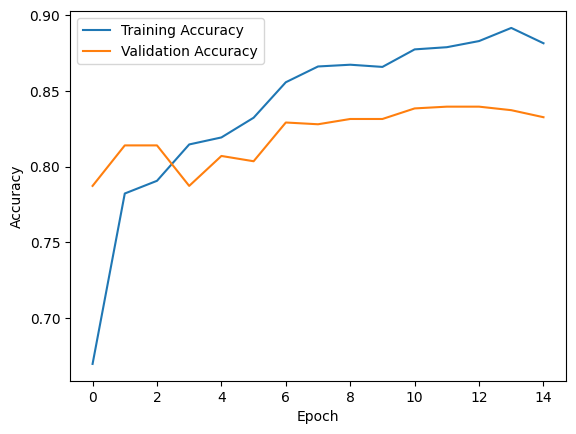

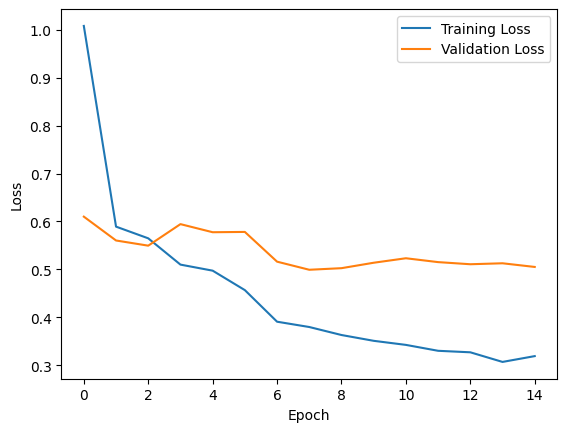

In [92]:
# Plotting model accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Saving 110472418_87b6a3aa98_m.jpg to 110472418_87b6a3aa98_m.jpg
Saving 10128546863_8de70c610d.jpg to 10128546863_8de70c610d.jpg
Saving 10140303196_b88d3d6cec.jpg to 10140303196_b88d3d6cec.jpg
Saving 10294487385_92a0676c7d_m.jpg to 10294487385_92a0676c7d_m.jpg
Saving 10386525005_fd0b7d6c55_n.jpg to 10386525005_fd0b7d6c55_n.jpg
Saving daisy.jpg to daisy.jpg
Saving dandelion.jpg to dandelion.jpg
Saving rose.jpg to rose.jpg
Saving sunflower.jpg to sunflower.jpg
Saving tulip.jpg to tulip.jpg
1/1 [==============================] - 0s 25ms/step


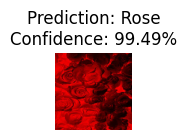

1/1 [==============================] - 0s 24ms/step


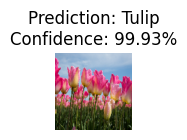

1/1 [==============================] - 0s 24ms/step


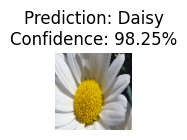

1/1 [==============================] - 0s 23ms/step


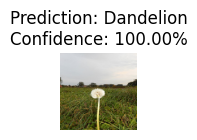

1/1 [==============================] - 0s 22ms/step


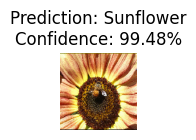

1/1 [==============================] - 0s 25ms/step


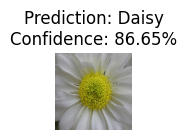

1/1 [==============================] - 0s 22ms/step


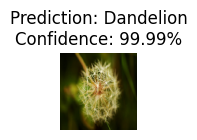

1/1 [==============================] - 0s 25ms/step


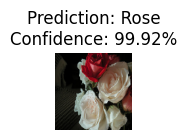

1/1 [==============================] - 0s 24ms/step


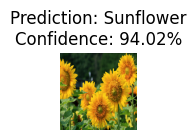

1/1 [==============================] - 0s 23ms/step


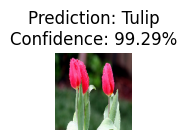

In [103]:
# Define classes
classes = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip',]

# Function to predict uploaded images
def predict_uploaded_image(model):
    uploaded_files = files.upload()

    for file_name in uploaded_files.keys():
        img_path = file_name
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)

        plt.figure(figsize=(1, 1))

        if predicted_class_index < len(classes):
            predicted_class = classes[predicted_class_index]
            confidence = np.max(prediction) * 100

            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2f}%')
            plt.show()
        else:
            print("Sorry, the prediction cannot be determined. The image is outside of the trained categories.")

# Calling the function to predict uploaded images
predict_uploaded_image(model)